In [1]:
import json

import numpy as np
from disentanglement_error.disentangling_model import DisentanglingModel
from disentanglement_error.error_metric import calculate_disentanglement_error
from sklearn.metrics import accuracy_score
from keras import Sequential
from keras.layers import Dense, Input
from keras.callbacks import EarlyStopping
from keras_uncertainty.models import StochasticClassifier
from keras_uncertainty.layers import StochasticDropout

from disentanglement_error.util import json_results_to_df


def entropy(probs, axis=-1, eps=1e-6):
    return -np.sum(probs * np.log(probs + eps), axis=axis)


def predictive_entropy(probs, axis=-1) -> np.ndarray:
    probs = np.mean(probs, axis=0)
    return entropy(probs, axis)


def expected_entropy(probs, eps=1e-6) -> np.ndarray:
    return -np.mean((probs * np.log(probs + eps)).sum(axis=-1), axis=0)


def mutual_information(probs) -> np.ndarray:
    return predictive_entropy(probs) - expected_entropy(probs)


class WineITModel(DisentanglingModel):

    def __init__(self):
        super().__init__()

    def fit(self, X, y):
        model = Sequential()
        model.add(Input(13))
        model.add(Dense(32, activation='relu'))
        model.add(StochasticDropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(StochasticDropout(0.2))
        model.add(Dense(32, activation='relu'))
        model.add(StochasticDropout(0.2))
        model.add(Dense(3, activation='softmax'))

        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
        model.fit(X, y, epochs=50, batch_size=16, callbacks=EarlyStopping(monitor='loss', patience=3), verbose=0)
        self.model = StochasticClassifier(model)


    def predict_disentangling(self, x_test):
        stochastic_preds = self.model.predict_samples(x_test, num_samples=30, batch_size=32)

        classifications = stochastic_preds.mean(axis=0).argmax(axis=1)
        aleatorics = expected_entropy(stochastic_preds)
        epistemics = mutual_information(stochastic_preds)
        return classifications, aleatorics, epistemics


    def score(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)

    def is_regression(self):
        return False

Keras Uncertainty will use standalone Keras backend

In [2]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder, StandardScaler

X, y = load_wine(return_X_y=True)

le = LabelEncoder()
y = le.fit_transform(y)

sc = StandardScaler()
X = sc.fit_transform(X)


kw_config = {"n_runs": 3,
}

de, result_json, config_json = calculate_disentanglement_error(X, y, WineITModel(), kw_config=kw_config)
print(de)

0.9293543568011761


Experiment
Decreasing Dataset    Axes(0.125,0.11;0.775x0.77)
Label Noise           Axes(0.125,0.11;0.775x0.77)
dtype: object

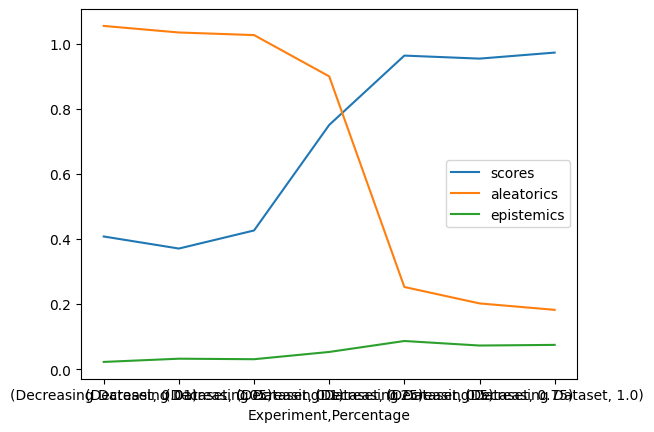

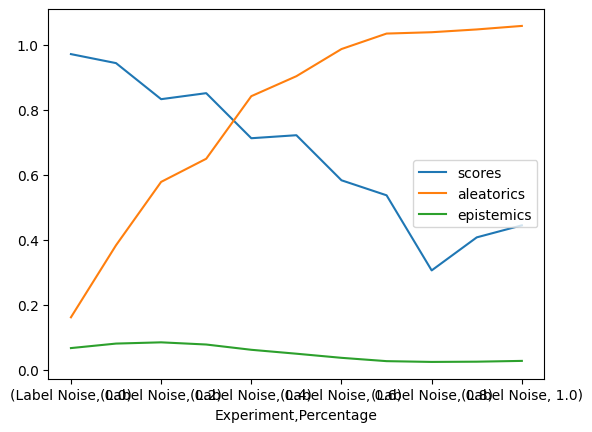

In [3]:
from disentanglement_error.util import json_results_to_df
df = json_results_to_df(result_json, config_json)
df.drop("Run_Index", axis=1).groupby(["Experiment", "Percentage"]).mean().groupby(['Experiment']).plot()